In [2]:
from langchain_groq import ChatGroq
from dotenv import load_dotenv

load_dotenv()
llm = ChatGroq(model="llama-3.3-70b-versatile")

In [63]:
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage, AnyMessage
from langgraph.graph.message import add_messages
from langgraph.types import Command, interrupt
from langgraph.checkpoint.memory import InMemorySaver

from pydantic import BaseModel, Field, ValidationError
from typing import Annotated, Literal
import json
import re

class CustomBaseModel(BaseModel):
    @classmethod
    def get_json_schema(cls) -> str: 
        return json.dumps(cls.model_json_schema()["properties"])

class Goal(CustomBaseModel):
    name: str = Field("Name of the goal that user is trying to achieve")
    amount: float = Field("Amount that user is trying to save for the given goal")

class UserProfile(CustomBaseModel):
    income: float = Field(description="monthly income")
    expenses: float = Field(description="monthly expenses")
    tolerance: Literal["low", "medium", "high"] = Field(description="Risk tolerance")
    preferences: list[str] = Field(default=[], description="A list of user's preferences where they'd like to invest.")
    goals: list[Goal] = Field(default=[], description="A list of goals that user is trying to achieve by investing")
    

In [64]:
def extract_content_from_tags(tag_name, txt: str):
    match = re.search(f"<{tag_name}>(.*?)</{tag_name}>", txt, re.DOTALL)
    return match[1] if match else None

In [75]:
class SharedState(BaseModel):
    messages: Annotated[list[AnyMessage], add_messages] = Field(default=[])
    user_profile: UserProfile = Field(default=None, description="contains information regarding User's income/expenses/their risk tolerance etc.")
    question_to_ask: str | None = Field(default=None)
    user_response: str | None = Field(default=None)
    risk_report: str = Field(default=None)
    risk_flags: list[str] = Field(default=[])
    disposable_income: int | float = Field(default=0)

    recommender_agent_summary: dict = Field(default={})

In [76]:
def collect_user_profile(state: SharedState):
    prompt_template = """
    You are a financial assistant. Your task is to extract a user's financial profile from their message, strictlyt following the provided JSON schema.

    Instructions:
    1. Use the JSON schema provided in <schema></schema> as an example to determine which fields to extract, their types, and any default values.
    2. If a field is missing in the user's input but has a default in the schema use that default.
        - If the field is mandatory and missing, Generate a short descriptive question and (if mthere are multiple questions to ask, unify and ask as single) and enclose it within <question_to_ask></question_to_ask>

    3. only include fields defined in the schema.
    4. output valid JSON
    5. Do not add any extra fields
    6. Do not make any assumptions. Strictly follow the guidelines

    <schema>
    %s
    </schema>

    This is the input example:
    "I earn 5000$ per month and I spend 3000$. I want to save 2000$ for a vacation."

    Example of expected JSON output(wrap the JSON within <generated_json></generated_json> tags):
    {
        "income": 5000,
        "expenses": 3000,
        "tolerance": "medium",
        "preferences": [],
        "goals: [{"name": "vacation", "amount": 2000}]
    }
    """
    system_message = SystemMessage(prompt_template % UserProfile.get_json_schema())
    
    try:
        llm_response = llm.invoke([system_message] + state.messages)
        extracted_content = extract_content_from_tags("question_to_ask", llm_response.content)
        if extracted_content is not None:
            state.messages = [] + [llm_response]
            state.question_to_ask = extracted_content
            return state

        extracted_content = extract_content_from_tags("generated_json", llm_response.content)
        extracted_json = json.loads(extracted_content)
        user_profile = UserProfile(**extracted_json)
        
    except ValidationError as e:
        print("validation error!")
        user_profile = None
        
    state.question_to_ask = None
    state.user_response = None
    state.messages = [llm_response]
    state.user_profile = user_profile
    return state

def should_ask_to_clarify(state: SharedState) -> Literal["ask_user_to_clarify", "risk_check_agent"]:
    user_profile = state.user_profile
    
    if user_profile is None or user_profile.income == 0 or user_profile.expenses == 0:
        return "ask_user_to_clarify"
    
    return "risk_check_agent"
    
def ask_user_to_clarify(state: SharedState) -> Command[Literal["collect_user_profile"]]:
    user_response = interrupt(f"\n {state.question_to_ask}")
    return Command(goto="collect_user_profile", update={"messages": [AIMessage(state.question_to_ask), HumanMessage(user_response)]})
      
def risk_check_agent(state: SharedState):
    system_prompt = SystemMessage("""You are a financial risk assessment assistant.
    Your task is to review a user's financial profile and explain potential risks and feasability of their financial situation.

    You will be provided with:
    1. The user's profile (income,  expenses, risk tolerance, goals, preferences).

    Instructions:
    - Carefully read the profile
    - Provide a concise but clear "Risk report" in plain English.
    - Explicitly explain why each risk flag matters in user-friendly terms
    - If the user's risk tolerance is misaligned with their financial reality highlight it
    - If goals are unrealistic suggest adjustments. (e.g. smaller goals, longer timeframe)
    - Maintain a supportive and professional tone
    - Do not invent numbers. Rely only on provided profile and calculations
    - Keep your output in under 150-200 words.
    """)

    profile = state.user_profile
    risk_flags = []
    disposable_income = profile.income - profile.expenses

    if disposable_income < 0:
        risk_flags.append("Negative cash flow")
    elif disposable_income < profile.income * 0.1:
        risk_flags.append("Low disposable income (<10% of income)")

    if profile.tolerance == "high" and disposable_income < profile.income * 0.1:
        risk_flags.append("High risk tolerance misaligned with limited finances")

    for goal in profile.goals:
        if goal.amount > disposable_income * 12:
            risk_flags.append(f"Goal '{goal.name}' may be unrealistic with current savings")

    llm_input = {
        "profile": profile.model_dump(),
        "calculations": {
            "disposable_income": disposable_income,
            "risk_flags": risk_flags
        }
    }

    res = llm.invoke([system_prompt, HumanMessage(json.dumps(llm_input))])

    state.messages = [res]
    state.risk_report = res.content
    state.risk_flags = risk_flags
    state.disposable_income = disposable_income
    return state


def investment_recommender_agent(state: SharedState):
    system_prompt = SystemMessage("""
    You are a professional financial advisor. Your job is to create an investment strategy for a user based on their financial profile and risk assessment.
    1. You will receive user's profile(income, monthly expenses, risk tolerance, goals, preferences)
    2. Calculation of (disposable income, risk flags and report)

    Instructions:
    - Only suggest investmets that match the user's risk tolerance and financial situation.
    - If disposable income is very low or negative, advise to increase savings before investing.
    - Align suggested investments with the user's goals. (short-term vs long-term)


    This is the JSON format of the output.: 
    {
        "recommendations": [
        "type": "<risk category or goal alignment>",
        "options": ["<investment options>"],
        "reasoning": "<brief explanation>"
        ],
        "investment_summary": "<user facing summary in plain english loanguage>"
    }

    
    Things to keep in mind:
    - Use realistic investment options (stocks, ETFs, bonds, saving accounts, crypto and others)
    - Provide a short reasoning for each recommendation.
    - Maintain a supportive and educational tone.
    - Do not invent any kind of number. Rely only on the provided user profile and calculations.
    - Keep JSON strictly valid without adding any extra fields.
    - Output plain JSON without anything additional
    """)

    llm_input = {
        "profile": state.user_profile.model_dump(),
        "risk_assesment": {
            "disposable_income": state.disposable_income,
            "risk_flags": state.risk_flags,
            "risk_report": state.risk_report
        }
    }
    human_message = HumanMessage(json.dumps(llm_input))

    res = llm.invoke([system_prompt, human_message])
    extracted_json = json.loads(res.content)
    state.recommender_agent_summary = extracted_json
    return state
    

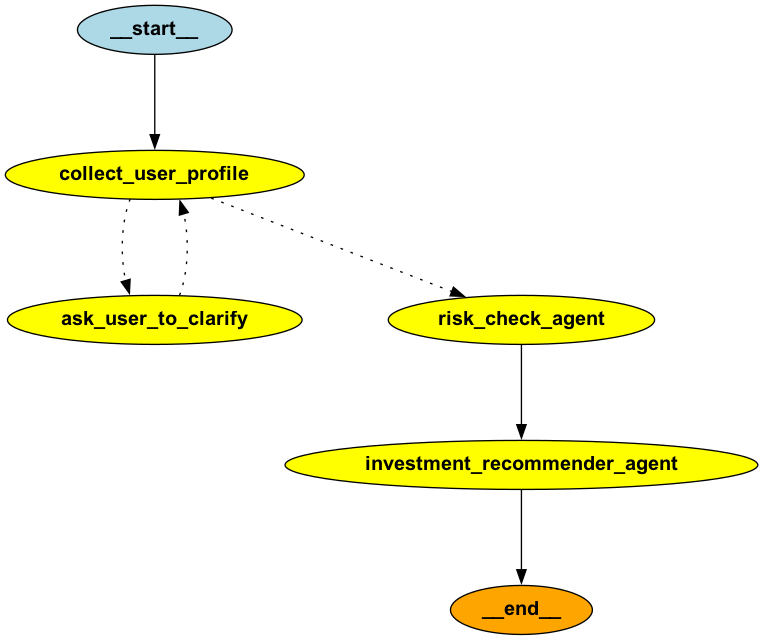

In [77]:
builder = StateGraph(SharedState)
builder.add_node(collect_user_profile)
builder.add_node(ask_user_to_clarify)
builder.add_node(risk_check_agent)
builder.add_node(investment_recommender_agent)

builder.set_entry_point("collect_user_profile")
builder.add_conditional_edges("collect_user_profile", should_ask_to_clarify)
builder.add_edge("risk_check_agent", "investment_recommender_agent")

graph = builder.compile(checkpointer=InMemorySaver(),)
from IPython.display import Image
graph_image = Image(graph.get_graph().draw_png())
graph_image

In [78]:
config = {"configurable": {"thread_id": 2}}
state = SharedState(messages=[HumanMessage("I want to purchase a house. I'm making 3k a month and spending 2k a month. I want to have low risk preference and I want to save 50000 dollars")])

In [79]:
graph.invoke(state, config)

{'messages': [HumanMessage(content="I want to purchase a house. I'm making 3k a month and spending 2k a month. I want to have low risk preference and I want to save 50000 dollars", additional_kwargs={}, response_metadata={}, id='dea3aee4-7b74-49e3-88a7-2453b7c5b95e'),
  AIMessage(content='To generate the user\'s financial profile, I will extract the relevant information from the input message based on the provided JSON schema.\n\nGiven the input:\n"I want to purchase a house. I\'m making 3k a month and spending 2k a month. I want to have low risk preference and I want to save 50000 dollars"\n\nExtracted fields:\n- Income: 3000\n- Expenses: 2000\n- Tolerance: low\n- Goals: Since the goal is to purchase a house and save $50,000, we can define the goal as {"name": "house", "amount": 50000}\n\nThe field "preferences" is missing, but according to the schema, it has a default value of an empty array.\n\nGenerated JSON:\n<generated_json>\n{\n    "income": 3000,\n    "expenses": 2000,\n    "to

In [35]:
interrupts = graph.get_state(config).interrupts

if interrupts:
    user_response = input(interrupts[0].value)
    graph.invoke(Command(resume=user_response), config)


 What is the amount you want to save for purchasing a house? 50000


HEREEE {'profile': {'income': 3000.0, 'expenses': 2000.0, 'tolerance': 'low', 'preferences': [], 'goals': [{'name': 'house', 'amount': 50000.0}]}, 'calculations': {'disposable_income': 1000.0, 'risk_flags': ["Goal 'house' may be unrealistic with current savings"]}}


/var/folders/st/7yxg30452v701hb8jhrdfm3h0000gn/T/ipykernel_57550/972246438.py:102: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  "profile": profile.dict(),


In [70]:
for m in graph.get_state(config).values["messages"]:
    m.pretty_print()
    

================================ Human Message =================================

I want to purchase a house. I'm making 3k a month and spending 2k a month. I want to have low risk preference and I want to save 50000 dollars
================================== Ai Message ==================================

To generate the user's financial profile based on the provided JSON schema, we'll extract the relevant information from the user's message.

From the message:
- Income: 3000 dollars per month
- Expenses: 2000 dollars per month
- Risk tolerance (implied as "low risk preference"): low
- Goal: to save 50000 dollars for purchasing a house

Since the schema defines "goals" as an array of objects with a specific structure (referencing a "$defs/Goal" which is not directly provided in the schema snippet but implied to have "name" and "amount" based on the example), and "preferences" as an array of strings, we will fill in the information accordingly. However, the exact structure of "Goal" is 